In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
pynrc.setup_logging('WARN', verbose=False)
    
import astropy.io.fits as fits

In [3]:
# Initialize a NIRCam Grism observation in Stripe mode 
nrc = pynrc.NIRCam('F444W', pupil='GRISM0', module='A', 
                   wind_mode='STRIPE', xpix=2048, ypix=64, fov_pix=64)

In [8]:
# Update ramp settings
nrc.update_detectors(read_mode='BRIGHT1', nint=100, ngroup=36, verbose=True)

New Ramp Settings:
  read_mode :  BRIGHT1
  nf        :        1
  nd2       :        1
  ngroup    :       36
  nint      :      100
New Detector Settings
  wind_mode :   STRIPE
  xpix      :     2048
  ypix      :       64
  x0        :        0
  y0        :        0
New Ramp Times
  t_group   :    0.681
  t_frame   :    0.341
  t_int     :   24.183
  t_int_tot :   24.524
  t_exp     : 2418.331
  t_acq     : 2452.392


In [5]:
# Setup Pysynphot spectrum of the source
# K7V star normalized to K=10.2 mag
bpk = S.ObsBandpass('johnson,k')
sp = pynrc.stellar_spectrum('G2V', 8, 'vegamag', bpk)

In [9]:
# Specify name of output file.
# Time stamps will be automatically inserted for unique file names.
file_out = '/Volumes/NIRData/grism_sim/grism_sim.fits'

%time nrc.gen_exposures(sp, file_out)

17
CPU times: user 8.24 s, sys: 1.18 s, total: 9.42 s
Wall time: 3min 13s


In [10]:
# Plot the ideal grism spectrum and slope image
w, im_slope = nrc.gen_psf(sp)

1442.79304903


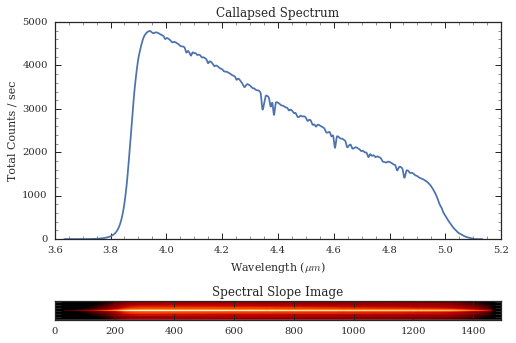

In [11]:
# For fun, plot the collapsed spectral image w.r.t. wavelength
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(7,1)
ax1 = plt.subplot(gs[:-2, :])
ax2 = plt.subplot(gs[-1, :])

# Collapsed spectrum
ax1.plot(w, im_slope.sum(axis=0))
ax1.set_ylabel('Total Counts / sec')
ax1.set_xlabel('Wavelength ($\mu m$)')
ax1.set_title('Callapsed Spectrum')
ax1.minorticks_on()

# Show the 2D spectral image as well
vmin = 1e-2
vmax = im_slope.max()
print(vmax)
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
ax2.imshow(im_slope, norm=norm)
ax2.set_title('Spectral Slope Image')
ax2.set_yticklabels('');

In [12]:
# The current image size is only as large as the dispersed spectrum
# Expand image to the larger detector size
xpix = nrc.det_info['xpix']
ypix = nrc.det_info['ypix']
im_slope = nrc_utils.pad_or_cut_to_size(im_slope, (ypix,xpix))
im_slope[im_slope==0] = im_slope[im_slope>0].min()